In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

2023-12-12 14:26:50.541853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 14:26:50.666922: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 14:26:50.670683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-12 14:26:50.670704: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load your dataset
df = pd.read_csv('updated_Data_till_T0_2-75_durga_oct17.csv')

# Shuffle the DataFrame
data = df.sample(frac=1, random_state=42)

# Select the first 100 rows for training and testing
data = data[:3_00_000]

In [3]:
# Define input features and target variables
input_features = ['n1', 'l1', 'j1', 'LP', 'Te', 'Z', 'A', 'Rfq', 'T0' ]
target_variables = ['n2', 'l2', 'j2', 'n3', 'l3', 'j3']


In [4]:
# Split the dataset into input (X) and target (y) variables
X = data[input_features]
y = data[target_variables]

# Normalize input features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# Define the ANN model as a function
def create_model(learning_rate=0.001, num_units=64, activation='relu'):
    model = models.Sequential([
        layers.Dense(num_units, activation=activation, input_shape=(9,)),
        layers.Dense(num_units, activation=activation),
        layers.Dense(6)  # Output layer with 6 units for n2, l2, j2, n3, l3, j3
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [6]:
# Define a function to perform manual hyperparameter tuning
def manual_hyperparameter_tuning(learning_rate_candidates, num_units_candidates, activation_candidates):
    best_mae = float('inf')
    best_hyperparameters = None
    best_history = None

    for lr in learning_rate_candidates:
        for num_units in num_units_candidates:
            for activation in activation_candidates:
                model = create_model(learning_rate=lr, num_units=num_units, activation=activation)
                history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
                y_pred = model.predict(X_test)
                mae = mean_absolute_error(y_test, y_pred)

                if mae < best_mae:
                    best_mae = mae
                    best_hyperparameters = {'learning_rate': lr, 'num_units': num_units, 'activation': activation}
                    best_history = history
                    best_model = model  # Store the best model

    return best_hyperparameters, best_history ,best_model ,best_mae

# Define candidate hyperparameter values
learning_rate_candidates = [0.001, 0.01, 0.1]
num_units_candidates = [32, 64, 128]
activation_candidates = ['relu', 'tanh']


In [7]:
# Perform manual hyperparameter tuning
best_hyperparameters, best_history, best_model,best_mae = manual_hyperparameter_tuning(learning_rate_candidates, num_units_candidates, activation_candidates)

2023-12-12 14:27:15.952922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-12 14:27:15.953006: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-12 14:27:15.953048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HPG-01): /proc/driver/nvidia/version does not exist
2023-12-12 14:27:15.953579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1875/1875 [==============================] - 1s 604us/step


In [8]:
best_hyperparameters

{'learning_rate': 0.001, 'num_units': 128, 'activation': 'tanh'}

In [9]:
tr_loss =  best_history.history['loss']
vl_loss =  best_history.history['val_loss']
tr_mae = best_history.history['mean_absolute_error']
vl_mae = best_history.history['val_mean_absolute_error']

In [11]:
np.min(tr_loss),np.min(vl_loss),np.min(tr_mae),np.min(vl_mae)

(0.5653194189071655,
 1.0544542074203491,
 0.5543230175971985,
 0.7645727396011353)

In [10]:
np.min(tr_loss),np.min(vl_loss),np.min(tr_mae),np.min(vl_mae)

(0.12615077197551727,
 0.12804582715034485,
 0.22222161293029785,
 0.21987079083919525)

In [11]:
tt = np.array(best_history.history['val_mean_absolute_error'])/np.array(best_history.history['mean_absolute_error'])

In [12]:
best_mae

0.22286366805022373

In [1]:
plt.plot(np.linspace(0,100,100),tt)

NameError: name 'plt' is not defined

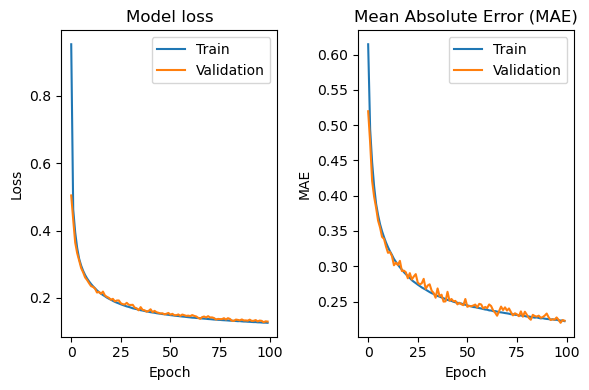

In [14]:
# Plot learning curves
plt.figure(figsize=(6,4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(best_history.history['mean_absolute_error'])
plt.plot(best_history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


1875/1875 [==============================] - 2s 792us/step


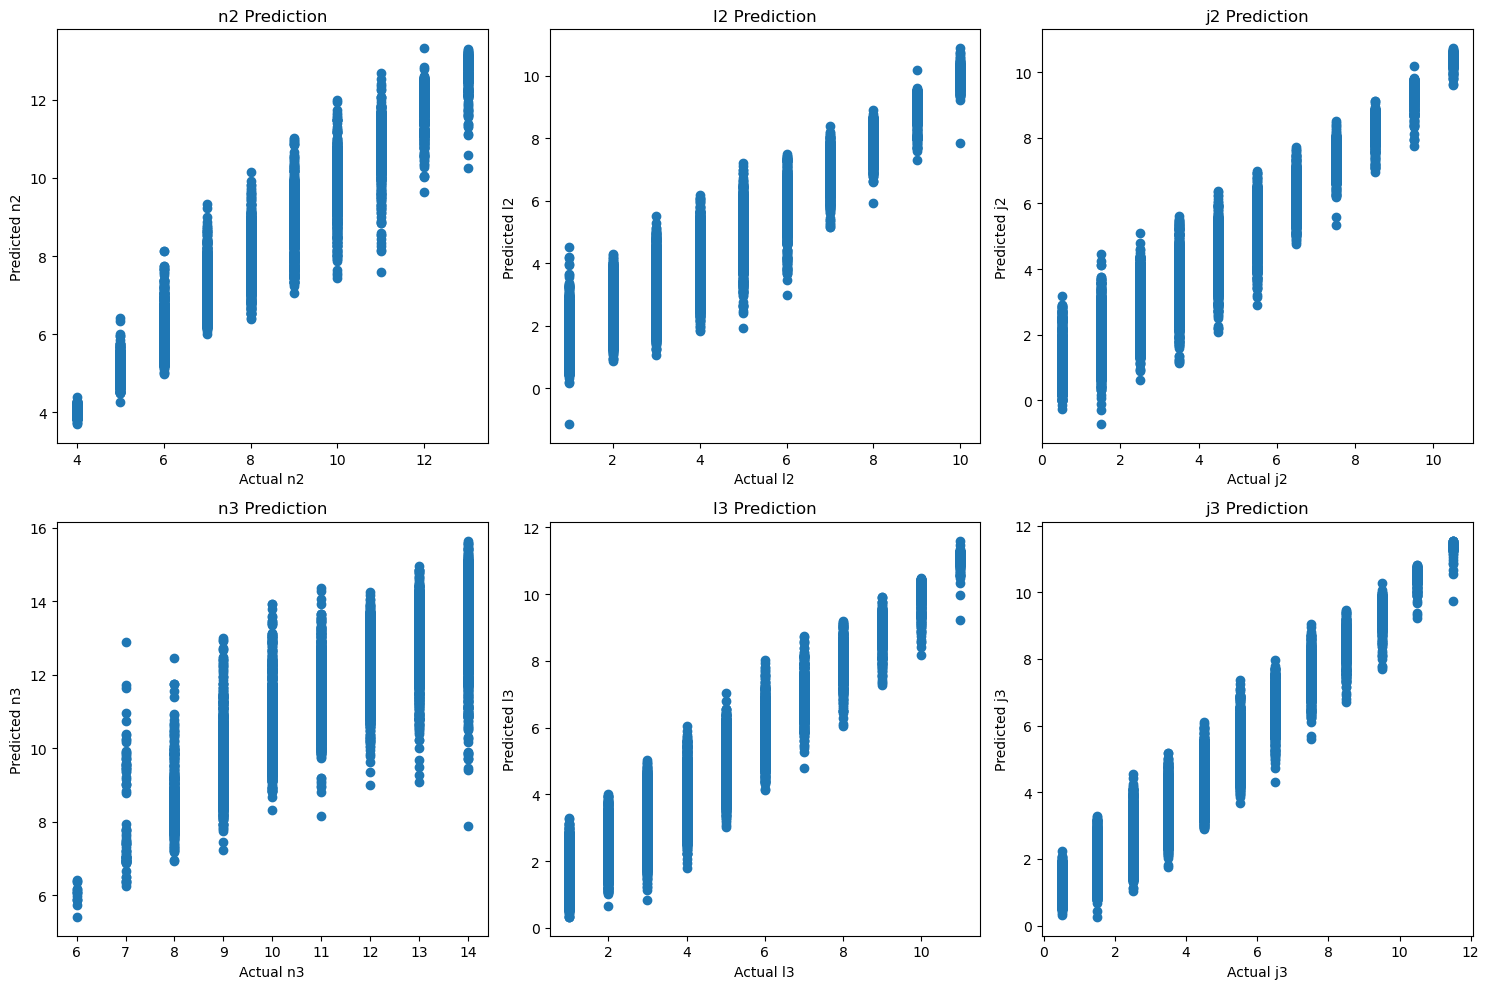

In [15]:
# Plot results for n2, l2, j2, n3, l3, j3 separately
y_pred = best_model.predict(X_test)
y_test = pd.DataFrame(y_test, columns=target_variables)  # Define y_test if it's not defined

plt.figure(figsize=(15, 10))
for i, target in enumerate(target_variables):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test[target], y_pred[:, i])
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'{target} Prediction')
plt.tight_layout()
plt.show()

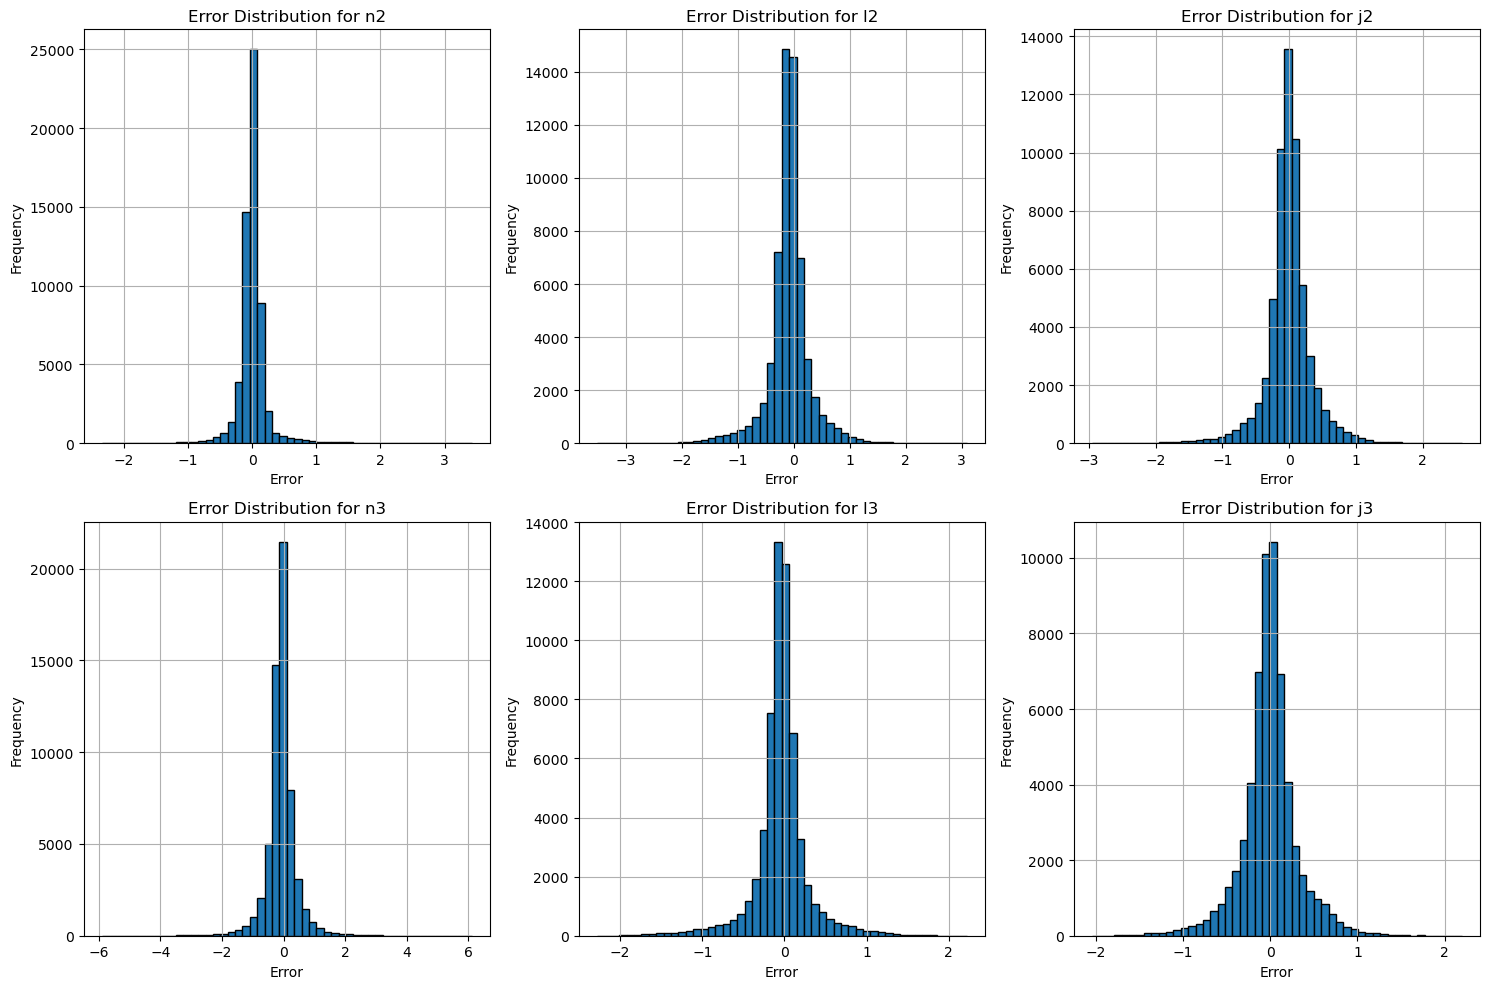

In [16]:
# Calculate the absolute errors
errors = y_test.values - y_pred

# Plot individual error distributions for each target variable
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_variables):
    plt.subplot(2, 3, i + 1)
    plt.hist(errors[:, i], bins=50, edgecolor='k')
    plt.title(f'Error Distribution for {target}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()